In [1]:
import numpy as np
import pylab as plt
import networkx as nx
import scipy.integrate as integ
from scipy.linalg import null_space
import math

from utils import *

%matplotlib inline

In [2]:
def ntri(A):
    # signed incidence matrices for triangles
    Nn=A.shape[0]
    Ne=int(np.sum(A)/2)
    #print Nn, Ne

    e=np.zeros((Ne,2))
    count=0;
    for i in range(Nn):
        for j in range(i+1,Nn):
            if(A[i,j]>0):
                e[count,0]=i
                e[count,1]=j
                count+=1
    print "edges"
    print e
    I=np.zeros((Ne,Nn))
    for i in range(Ne):
        I[i,int(e[i,0])]=1
        I[i,int(e[i,1])]=-1
    #print I

    Nf=0
    for i in range(Nn):
        for j in range(i+1,Nn):
            for k in range(j+1,Nn):
                subA=A[np.ix_([i,j,k],[i,j,k])]
                if(np.sum(subA)==6):
                    Nf+=1
    f=np.zeros((Nf,3))
    count=0
    for i in range(Nn):
        for j in range(i+1,Nn):
            for k in range(j+1,Nn):
                subA=A[np.ix_([i,j,k],[i,j,k])]
                if(np.sum(subA)==6):
                    f[count,0]=i
                    f[count,1]=j
                    f[count,2]=k
                    count+=1
    print "faces"
    print f
    II=np.zeros((Nf,Ne))
    for i in range(f.shape[0]):
        for j in [0,-1,-2]:
            temp=np.roll(f[i,:],j)
            temp=temp[0:2]
            for k in range(e.shape[0]):
                #print e[k,:],temp
                if(((e[k,:]==temp).all())or((e[k,:]==np.roll(temp,1)).all())):
                    Irow=k
            if(temp[0]<temp[1]):
                II[i,Irow]=1
            else:
                II[i,Irow]=-1
    #print II 
    ntrie=np.sum(II,1)
    return I,II#,ntrie, e#, len(ntrie)

In [3]:
def simplicial_kuramoto_full_theta(t, theta, B0, B1, a, omega_0, degree, weights_n, weights_e, weights_f):
#     return omega_0-a*(1/np.absolute(B0).sum(1))*np.diag(we).dot(B0.dot(np.sin(B0.T.dot(theta))))-a*(1/np.absolute(B1).sum(0))*B1.T.dot(np.diag(wf).dot(np.sin(B1.dot(theta))))
    return omega_0-a*(B0.dot(np.sin(B0.T.dot(theta))))-a*B1.T.dot(np.sin(B1.dot(theta)))
#     return omega_0-a*np.diag(we).dot(B0.dot(np.sin(B0.T.dot(theta))))-a*B1.T.dot(np.diag(wf).dot(np.sin(B1.dot(theta))))

# L1w=np.diag(we).dot(B0.dot(B0.T))+B1.T.dot(np.diag(wf).dot(B1))
# L1w=B0.dot(np.diag(wn).dot(B0.T))+B1.T.dot(np.diag(wf).dot(B1))

def integrate_simplicial_kuramoto_full_theta(B0, B1, theta_0, t_max, n_t, a, omega_0, degree, weights_n, weights_e, weights_f):
    
    return integ.solve_ivp(lambda t, theta: simplicial_kuramoto_full_theta(t, theta, B0, B1, a, omega_0, degree, weights_n, weights_e, weights_f), [0, t_max], theta_0, t_eval = np.linspace(0, t_max, n_t),method='Radau',rtol=1.49012e-8,atol=1.49012e-8)

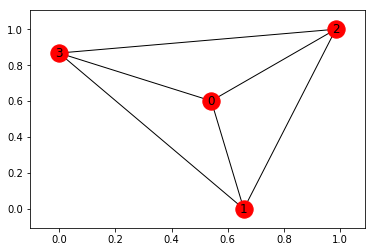

In [4]:
G=nx.complete_graph(4)

pos = nx.spring_layout(G)
# plt.figure()
# nx.draw(G,pos = pos,with_labels = True)
nx.draw_networkx(G, pos=pos)

In [5]:
# By hand
A=nx.adjacency_matrix(G).toarray()
Nn=len(G.nodes())
Ne=len(G.edges())
Nf=4

B0=np.zeros((Ne,Nn))
count=0
for i in range(Nn):
    for j in range(i+1,Nn):
        if(A[i,j]==1):
            B0[count,i]=1
            B0[count,j]=-1
            count+=1
# print B0
B1=np.zeros((Nf,Ne))
B1[0,:]=[1, -1, 0, 1, 0, 0] #123
B1[1,:]=[1, 0, -1, 0, 1, 0] #124
B1[2,:]=[0, 1, -1, 0, 0, 1] #143
B1[3,:]=[0, 0, 0, 1, -1, 1] #243
# print B1

L1=B0.dot(B0.T)+B1.T.dot(B1)
print L1

eigval, eigvec = np.linalg.eig(L1)
eig_sort = np.argsort(eigval)
eigval = eigval[eig_sort]
eigvec = eigvec[:,eig_sort]
print eigval

[[4. 0. 0. 0. 0. 0.]
 [0. 4. 0. 0. 0. 0.]
 [0. 0. 4. 0. 0. 0.]
 [0. 0. 0. 4. 0. 0.]
 [0. 0. 0. 0. 4. 0.]
 [0. 0. 0. 0. 0. 4.]]
[4. 4. 4. 4. 4. 4.]


In [6]:
wn=np.ones(Nn)
we=np.ones(Ne)
wf=np.zeros(Nf)
we[2]=0.01
we[3]=0.01
wf[0]=we[0]*we[1]*we[3]
wf[1]=we[1]*we[2]*we[5]
wf[2]=we[0]*we[2]*we[4]
wf[3]=we[3]*we[4]*we[5]

L1wdwn=np.diag(we).dot(B0.dot(B0.T))
L1wup=B1.T.dot(np.diag(wf).dot(B1))
L1w=L1wdwn+L1wup

eigval, eigvec = np.linalg.eig(L1w)
eig_sort = np.argsort(eigval)
eigval = eigval[eig_sort]
eigvec = eigvec[:,eig_sort]

print "L1dwn:", L1wdwn
print "L1up:", L1wup
print eigval

L1dwn: [[ 2.    1.    1.   -1.   -1.    0.  ]
 [ 1.    2.    1.    1.    0.   -1.  ]
 [ 0.01  0.01  0.02  0.    0.01  0.01]
 [-0.01  0.01  0.    0.02  0.01 -0.01]
 [-1.    0.    1.    1.    2.    1.  ]
 [ 0.   -1.    1.   -1.    1.    2.  ]]
L1up: [[ 0.02 -0.01 -0.01  0.01  0.01  0.  ]
 [-0.01  0.02 -0.01 -0.01  0.    0.01]
 [-0.01 -0.01  0.02  0.   -0.01 -0.01]
 [ 0.01 -0.01  0.    0.02 -0.01  0.01]
 [ 0.01  0.   -0.01 -0.01  0.02 -0.01]
 [ 0.    0.01 -0.01  0.01 -0.01  0.02]]
[0.04 0.04 0.04 2.02 2.02 4.  ]


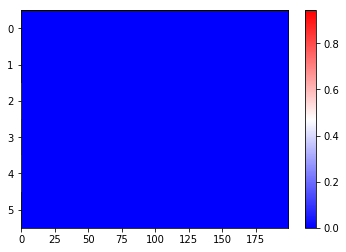

In [7]:
np.random.seed(seed=4444)

theta_0=np.random.rand(Ne)
omega_0=0#np.ones(Ne)*0

degree=np.absolute(B0).sum(0)
a=1

t_max = 1000 #integration time
n_t = 200 #number of timepoints 

wn=np.ones(Nn)
we=np.ones(Ne)
wf=np.ones(Nf)
we[2]=1
we[3]=1
wf[0]=we[0]*we[1]*we[3]
wf[1]=we[1]*we[2]*we[5]
wf[2]=we[0]*we[2]*we[4]
wf[3]=we[3]*we[4]*we[5]

result=integrate_simplicial_kuramoto_full_theta(B0, B1, theta_0, t_max, n_t, a, omega_0, degree, wn, we, wf)

times = result.t
theta = result.y

plt.figure()
plt.imshow(theta, aspect='auto',cmap='bwr')
plt.colorbar()

In [8]:
L1w=np.diag(we).dot(B0.dot(B0.T))+B1.T.dot(np.diag(wf).dot(B1))

eigval, eigvec = np.linalg.eig(L1w)
eig_sort = np.argsort(eigval)
eigval = eigval[eig_sort]
eigvec = eigvec[:,eig_sort]
print eigval

[4. 4. 4. 4. 4. 4.]


In [9]:
I,II=ntri(A)
print I
print II

edges
[[0. 1.]
 [0. 2.]
 [0. 3.]
 [1. 2.]
 [1. 3.]
 [2. 3.]]
faces
[[0. 1. 2.]
 [0. 1. 3.]
 [0. 2. 3.]
 [1. 2. 3.]]
[[ 1. -1.  0.  0.]
 [ 1.  0. -1.  0.]
 [ 1.  0.  0. -1.]
 [ 0.  1. -1.  0.]
 [ 0.  1.  0. -1.]
 [ 0.  0.  1. -1.]]
[[ 1. -1.  0.  1.  0.  0.]
 [ 1.  0. -1.  0.  1.  0.]
 [ 0.  1. -1.  0.  0.  1.]
 [ 0.  0.  0.  1. -1.  1.]]


edges
[[0. 1.]
 [0. 3.]
 [1. 2.]
 [2. 3.]]
faces
[]
[[ 1. -1.  0.  0.]
 [-1.  0.  0.  1.]
 [ 0.  1. -1.  0.]
 [ 0.  0.  1. -1.]]
[]
('Div: ', array([0., 0., 0., 0.]))
('Curl: ', array([], dtype=float64))
('\theta_0,\theta: ', array([3.00785506, 1.61166922, 1.89973923, 1.75597998]), array([2.06881087, 2.06881087, 2.06881087, 2.06881087]))
('L1\theta: ', array([-1.33226763e-15, -4.44089210e-16,  4.44089210e-16,  1.33226763e-15]))
('L1\theta: ', array([0., 0., 0., 0.]))
('dim(Ker(L1)): ', 1)
('Ker(L1): ', array([[-0.5],
       [-0.5],
       [-0.5],
       [-0.5]]))


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/axes/_base.py:3193: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  'bottom=%s, top=%s') % (bottom, top))


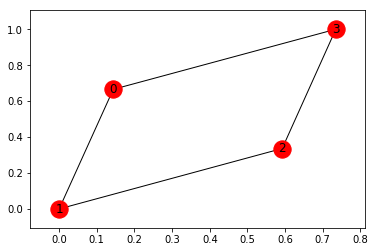

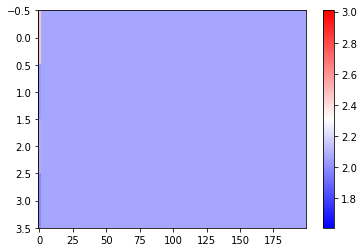

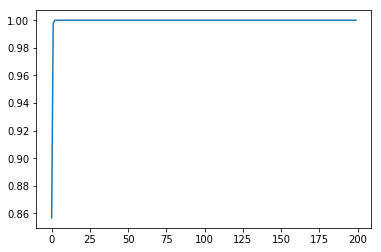

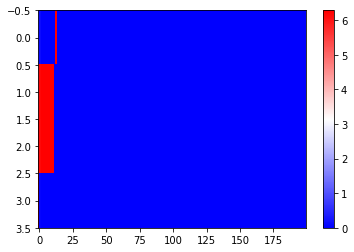

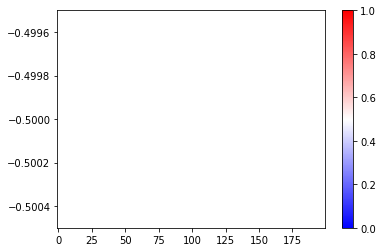

In [10]:
# no weights
# G=nx.complete_graph(3)
# G=nx.barbell_graph(4,2)
G=nx.cycle_graph(4)
# G=nx.Graph()
# for i in range(10):
#     G.add_node(i)
# for i in range(9):
#     G.add_edge(i,i+1)
# G=nx.cycle_graph(10)
# G.add_edge(0,2)
# plt.figure()
nx.draw_networkx(G)

A=nx.to_numpy_matrix(G)

B0,B1=ntri(A)

B0[1,0]=-B0[1,0]
B0[1,3]=-B0[1,3]

print B0
print B1

Nn=B0.shape[1]
Ne=B0.shape[0]
Nf=B1.shape[0]
wn=np.ones(Nn)
we=np.ones(Ne)
wf=np.ones(Nf)

# np.random.seed(seed=4444)

theta_0=np.pi*np.random.rand(Ne)
# theta_0=(np.random.rand(Ne)-0.5)*8
# theta_0=np.pi*np.ones(Ne)*3/2+0.1

omega_0=np.ones(Ne)*0

degree=np.absolute(B0).sum(0)
a=1

t_max = 200 #integration time
n_t = 200 #number of timepoints 

result=integrate_simplicial_kuramoto_full_theta(B0, B1, theta_0, t_max, n_t, a, omega_0, degree, wn, we, wf)

times = result.t
theta = result.y

plt.figure()
plt.imshow(np.mod(np.around(theta,10),np.around(2*np.pi,10)), aspect='auto',cmap='bwr')
plt.colorbar()

op=order_parameter(theta, 4, 1)
plt.figure()
plt.plot(op[0,:])

Div=np.mod(np.around(B0.T.dot(theta),10),np.around(2*np.pi,10))
Curl=np.mod(np.around(B1.dot(theta),10),np.around(2*np.pi,10))
print('Div: ', Div[:,-1])
print('Curl: ', Curl[:,-1])
print('\theta_0,\theta: ', theta_0,theta[:,-1])
L1=-B0.dot(B0.T)-B1.T.dot(B1)
print('L1\theta: ', L1.dot(theta[:,-1]))
print('L1\theta: ', np.mod(np.around(L1.dot(theta[:,-1]),10),np.around(2*np.pi,10)))
print('dim(Ker(L1)): ', null_space(L1).shape[1])
print('Ker(L1): ', null_space(L1))

plt.figure()
plt.imshow(Div, aspect='auto',cmap='bwr')
plt.colorbar()
plt.figure()
plt.imshow(Curl, aspect='auto',cmap='bwr')
plt.colorbar() 

('Div: ', array([0., 0., 0., 0.]))
('Curl: ', array([], dtype=float64))
('\theta_0,\theta: ', array([0.03243919, 2.95833609, 0.34531949, 3.61064097]), array([-1.31328044,  1.31328044, -1.31328044,  4.96990487]))
('L1\theta: ', array([-3.55271368e-15, -6.28318531e+00,  6.28318531e+00, -1.25663706e+01]))
('L1\theta: ', array([0., 0., 0., 0.]))
('dim(Ker(L1)): ', 1)
('Ker(L1): ', array([[-0.5],
       [ 0.5],
       [-0.5],
       [-0.5]]))


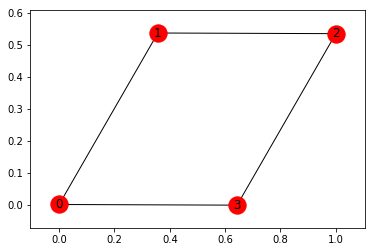

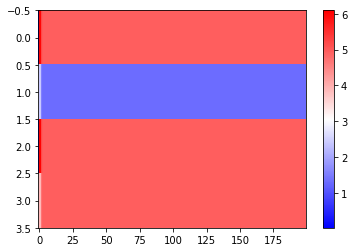

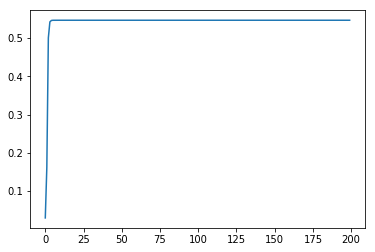

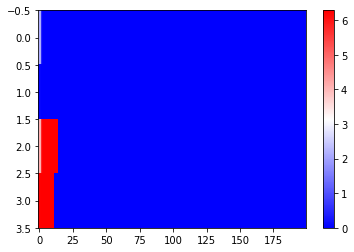

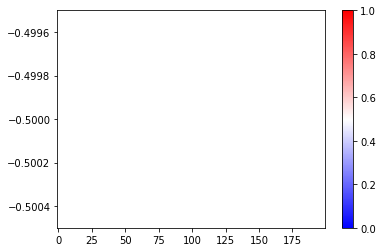

In [335]:
# cycle graph
Nn=4
Ne=4
Nf=0
G=nx.cycle_graph(Nn)
nx.draw_networkx(G)

A=nx.to_numpy_matrix(G)

# +-
B0=np.zeros((Ne,Nn))
B0[0,:]=[1, -1, 0, 0]
B0[1,:]=[1, 0, 0, -1]
B0[2,:]=[0, 1, -1, 0]
B0[3,:]=[0, 0, 1, -1]
# all ++
# B0=np.zeros((Ne,Nn))
# B0[0,:]=[1, -1, 0, 0]
# B0[1,:]=[0, -1, 1, 0]
# B0[2,:]=[0, 0, 1, -1]
# B0[3,:]=[1, 0, 0, -1]
# # one ++
# B0=np.zeros((Ne,Nn))
# B0[0,:]=[1, -1, 0, 0]
# B0[1,:]=[0, 1, -1, 0]
# B0[2,:]=[0, 0, 1, -1]
# B0[3,:]=[1, 0, 0, -1]

B1=np.zeros((Nf,Ne))

# np.random.seed(seed=4444)

theta_0=2*np.pi*np.random.rand(Ne)
# theta_0=(np.random.rand(Ne)-0.5)*10
# theta_0=np.mod(theta_0,2*np.pi)
# theta_0=np.pi*np.ones(Ne)*3/2+0.1
omega_0=np.ones(Ne)*0

degree=np.absolute(B0).sum(0)
a=1

t_max = 200 #integration time
n_t = 200 #number of timepoints 

result=integrate_simplicial_kuramoto_full_theta(B0, B1, theta_0, t_max, n_t, a, omega_0, degree, wn, we, wf)

times = result.t
theta = result.y

plt.figure()
plt.imshow(np.mod(np.around(theta,10),np.around(2*np.pi,10)), aspect='auto',cmap='bwr')
plt.colorbar()

op=order_parameter(theta, 4, 1)
plt.figure()
plt.plot(op[0,:])

Div=np.mod(np.around(B0.T.dot(theta),10),np.around(2*np.pi,10))
Curl=np.mod(np.around(B1.dot(theta),10),np.around(2*np.pi,10))
print('Div: ', Div[:,-1])
print('Curl: ', Curl[:,-1])
print('\theta_0,\theta: ', theta_0,theta[:,-1])
L1=-B0.dot(B0.T)-B1.T.dot(B1)
print('L1\theta: ', L1.dot(theta[:,-1]))
print('L1\theta: ', np.mod(np.around(L1.dot(theta[:,-1]),10),np.around(2*np.pi,10)))
print('dim(Ker(L1)): ', null_space(L1).shape[1])
print('Ker(L1): ', null_space(L1))

plt.figure()
plt.imshow(Div, aspect='auto',cmap='bwr')
plt.colorbar()
plt.figure()
plt.imshow(Curl, aspect='auto',cmap='bwr')
plt.colorbar() 

In [325]:
def plotflow(theta_0,B0,B1,plotname):
    omega_0=np.ones(Ne)*0
    degree=np.absolute(B0).sum(0)
    a=1
    t_max = 110 #integration time
    n_t = 200 #number of timepoints 
    result=integrate_simplicial_kuramoto_full_theta(B0, B1, theta_0, t_max, n_t, a, omega_0, degree, wn, we, wf)
    times = result.t
    theta = result.y
    plt.figure()
    plt.imshow(np.mod(np.around(theta,10),np.around(2*np.pi,10)), aspect='auto',cmap='bwr')
    plt.title(plotname+' phases')
    plt.colorbar()
    op=order_parameter(theta, 4, 1)
    plt.figure()
    plt.title(plotname+' order parameter')
    plt.plot(op[0,:])
    Div=np.mod(np.around(B0.T.dot(theta),10),np.around(2*np.pi,10))
    Curl=np.mod(np.around(B1.dot(theta),10),np.around(2*np.pi,10))
    print('Div: ', Div[:,-1])
    print('Curl: ', Curl[:,-1])
    print('\theta_0: ', theta_0)
    print('\theta: ',theta[:,-1])
    L1=-B0.dot(B0.T)-B1.T.dot(B1)
    print('L1\theta: ', L1.dot(theta[:,-1]))
    print('L1\theta: ', np.mod(np.around(L1.dot(theta[:,-1]),10),np.around(2*np.pi,10)))
    print('dim(Ker(L1)): ', null_space(L1).shape[1])
    print('Ker(L1): ', null_space(L1))
#     plt.figure()
#     plt.imshow(Div, aspect='auto',cmap='bwr')
#     plt.title(plotname+' divergence')
#     plt.colorbar()
#     plt.figure()
#     plt.imshow(Curl, aspect='auto',cmap='bwr')
#     plt.title(plotname+' curl')
#     plt.colorbar()

1++ 3+-, d+
('Div: ', array([0., 0., 0., 0.]))
('Curl: ', array([0., 0.]))
('\theta_0: ', array([ 4.48788274, -1.75068433,  2.63737595,  1.02848916, -0.0810343 ]))
('\theta: ', array([ 2.35619449, -0.78539816,  2.35619449,  0.78539816, -1.57079633]))
('L1\theta: ', array([-6.28318531e+00, -9.32587341e-14, -6.28318531e+00,  9.59232693e-14,
        6.28318531e+00]))
('L1\theta: ', array([0., 0., 0., 0., 0.]))
('dim(Ker(L1)): ', 0)
('Ker(L1): ', array([], shape=(5, 0), dtype=float64))
1+- 3+-, d+
('Div: ', array([6.6057800e-05, 3.4451000e-05, 0.0000000e+00, 6.2830848e+00]))
('Curl: ', array([6.28314096e+00, 1.29388600e-04]))
('\theta_0: ', array([ 4.48788274, -1.75068433,  2.63737595,  1.02848916, -0.0810343 ]))
('\theta: ', array([ 3.14143830e+00,  3.14114235e+00,  3.14147276e+00,  3.14124286e+00,
       -2.29897386e-04]))
('L1\theta: ', array([-6.28317256e+00,  3.71779745e-05, -6.28317541e+00,  2.88797797e-05,
        6.28320429e+00]))
('L1\theta: ', array([1.27434e-05, 3.71780e-05, 9.8

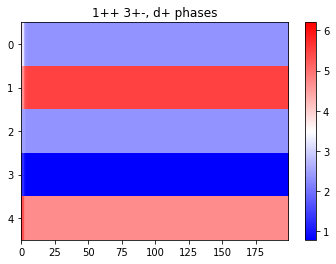

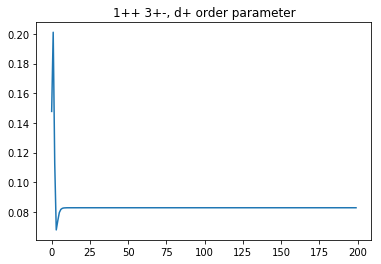

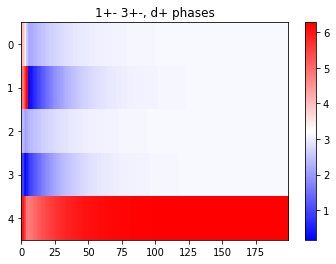

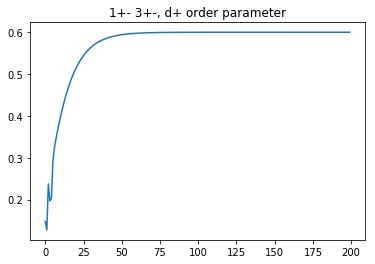

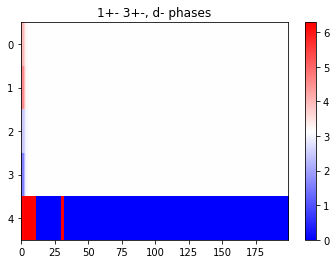

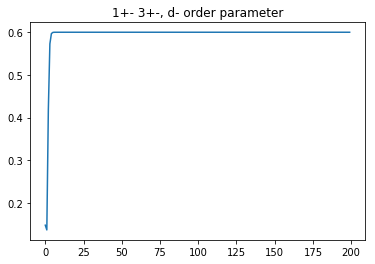

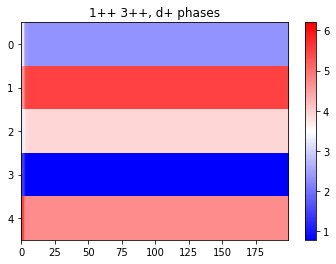

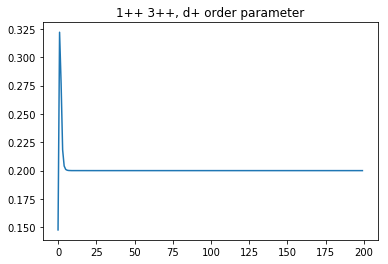

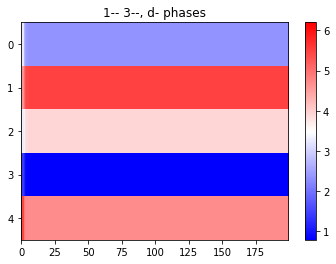

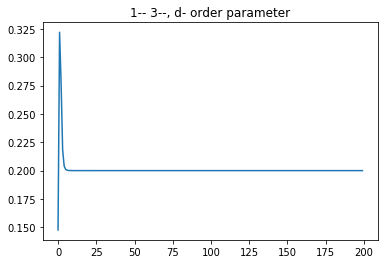

In [341]:
# cycle graph with diagonal
Nn=4
Ne=5
Nf=2
# G=nx.cycle_graph(Nn)
# G.add_edge(0,2)
# nx.draw_networkx(G)

# A=nx.to_numpy_matrix(G)

# np.random.seed(seed=4444)

# theta_0=np.pi*np.random.rand(Ne)
theta_0=(np.random.rand(Ne)-0.5)*10
# theta_0=np.zeros(Ne)
# theta_0=np.ones(Ne)
# theta_0=np.pi*np.ones(Ne)*3/2+0.1
# theta_0=np.mod(theta_0,2*np.pi)

# +- diag +
B0=np.zeros((Ne,Nn))
B0[0,:]=[1, -1, 0, 0]
B0[1,:]=[1, 0, 0, -1]
B0[2,:]=[0, 1, -1, 0]
B0[3,:]=[0, 0, 1, -1]
B0[4,:]=[1, 0, -1, 0]
B1=np.zeros((Nf,Ne))
B1[0,:]=[1, 0, 1, 0, -1] #e135 (n123)
B1[1,:]=[0, 1, 0, -1, -1] #e245 (n134)
print('1++ 3+-, d+')
plotflow(theta_0,B0,B1,'1++ 3+-, d+')

# # +- diag +
B0=np.zeros((Ne,Nn))
B0[0,:]=[1, -1, 0, 0]
B0[1,:]=[-1, 0, 0, 1]
B0[2,:]=[0, 1, -1, 0]
B0[3,:]=[0, 0, 1, -1]
B0[4,:]=[1, 0, -1, 0]
B1=np.zeros((Nf,Ne))
B1[0,:]=[1, 0, 1, 0, -1] #e135 (n123)
B1[1,:]=[0, 1, 0, -1, -1] #e245 (n134)
print('1+- 3+-, d+')
plotflow(theta_0,B0,B1,'1+- 3+-, d+')

# +- diag -
B0=np.zeros((Ne,Nn))
B0[0,:]=[1, -1, 0, 0]
B0[1,:]=[-1, 0, 0, 1]
B0[2,:]=[0, 1, -1, 0]
B0[3,:]=[0, 0, 1, -1]
B0[4,:]=[-1, 0, 1, 0]
B1=np.zeros((Nf,Ne))
B1[0,:]=[1, 0, 1, 0, 1] #135
B1[1,:]=[0, 1, 0, 1, -1] #245
print('1+- 3+-, d-')
plotflow(theta_0,B0,B1,'1+- 3+-, d-')

# ++(1) diag +
B0=np.zeros((Ne,Nn))
B0[0,:]=[1, -1, 0, 0]
B0[1,:]=[1, 0, 0, -1]
B0[2,:]=[0, -1, 1, 0]
B0[3,:]=[0, 0, 1, -1]
B0[4,:]=[1, 0, -1, 0]
B1=np.zeros((Nf,Ne))
B1[0,:]=[1, 0, -1, 0, -1] #135
B1[1,:]=[0, -1, 0, 1, 1] #245
print('1++ 3++, d+')
plotflow(theta_0,B0,B1,'1++ 3++, d+')

# ++(1) diag -
# B0=np.zeros((Ne,Nn))
# B0[0,:]=[1, -1, 0, 0]
# B0[1,:]=[1, 0, 0, -1]
# B0[2,:]=[0, -1, 1, 0]
# B0[3,:]=[0, 0, 1, -1]
# # B0[4,:]=[-1, 0, 1, 0]
# B1=np.zeros((Nf,Ne))
# B1[0,:]=[1, 0, -1, 0, 1] #135
# B1[1,:]=[0, -1, 0, 1, -1] #245
# print('1++ 3++, d-')
# plotflow(theta_0,B0,B1,1++ 3++, d-')

# --(1) diag +
# B0=np.zeros((Ne,Nn))
# B0[0,:]=[-1, 1, 0, 0]
# B0[1,:]=[-1, 0, 0, 1]
# B0[2,:]=[0, 1, -1, 0]
# B0[3,:]=[0, 0, -1, 1]
# B0[4,:]=[1, 0, -1, 0]
# B1=np.zeros((Nf,Ne))
# B1[0,:]=[-1, 0, 1, 0, -1] #135
# B1[1,:]=[0, 1, 0, -1, 1] #245
# print('1-- 3--, d+')
# plotflow(theta_0,B0,B1,'1-- 3--, d+')

# --(1) diag -
B0=np.zeros((Ne,Nn))
B0[0,:]=[-1, 1, 0, 0]
B0[1,:]=[-1, 0, 0, 1]
B0[2,:]=[0, 1, -1, 0]
B0[3,:]=[0, 0, -1, 1]
B0[4,:]=[-1, 0, 1, 0]
B1=np.zeros((Nf,Ne))
B1[0,:]=[-1, 0, 1, 0, 1] #135
B1[1,:]=[0, 1, 0, -1, -1] #245
print('1-- 3--, d-')
plotflow(theta_0,B0,B1,'1-- 3--, d-')

('Div: ', array([0., 0., 0., 0., 0., 0.]))
('Curl: ', array([], dtype=float64))
('\theta_0,\theta: ', array([1.75597998, 0.26061444, 2.25649767, 0.7545034 , 1.69678192,
       0.94926665, 1.90830584]), array([1.01032081, 1.54756054, 1.54756054, 1.54756054, 1.01032081,
       1.01032081, 0.53723973]))
('L1\theta: ', array([ 4.69069228e-13, -8.76521078e-13, -6.23501251e-13,  6.06181771e-13,
        2.40918396e-13,  1.84074977e-13,  8.93507490e-13]))
('L1\theta: ', array([0., 0., 0., 0., 0., 0., 0.]))
('dim(Ker(L1)): ', 2)
('Ker(L1): ', array([[ 0.45644438, -0.24150609],
       [ 0.34794836,  0.38157385],
       [ 0.34794836,  0.38157385],
       [ 0.34794836,  0.38157385],
       [ 0.45644438, -0.24150609],
       [ 0.45644438, -0.24150609],
       [-0.10849602,  0.62307994]]))


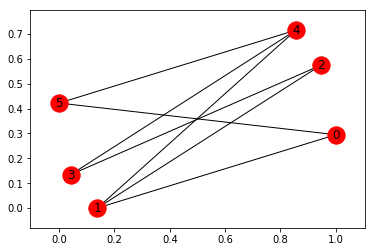

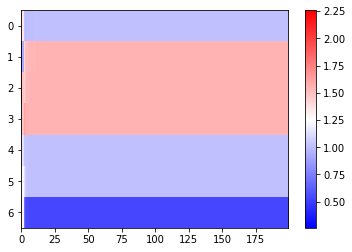

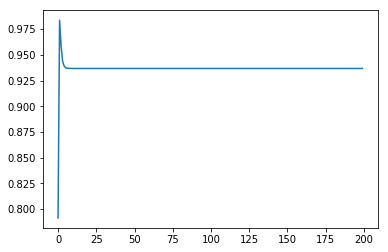

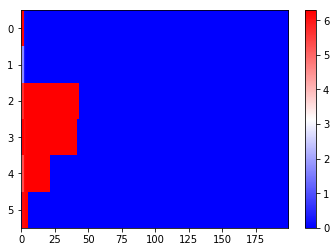

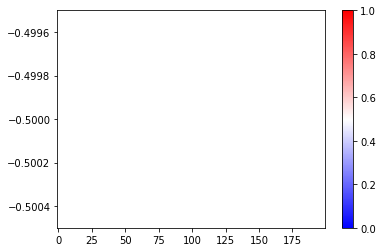

In [13]:
# 00
Nn=6
Ne=7
Nf=0
B0=np.zeros((Ne,Nn))
B0[0,:]=[-1, 1, 0, 0, 0, 0]
B0[1,:]=[0, -1, 1, 0, 0, 0]
B0[2,:]=[0, 0, -1, 1, 0, 0]
B0[3,:]=[0, 0, 0, -1, 1, 0]
B0[4,:]=[0, 0, 0, 0, -1, 1]
B0[5,:]=[1, 0, 0, 0, 0, -1]
B0[6,:]=[0, 1, 0, 0, -1, 0]
# B0[7,:]=[0, 1, 0, -1, 0, 0]
B1=np.zeros((Nf,Ne))
# B1[0,:]=[0, 1, 1, 0, 0, 0, 0, 1] #135
# B1[1,:]=[0, 0, 0, 1, 0, 0, -1, -1] #245

G=nx.from_numpy_matrix(B0.T.dot(B0))
nx.draw_networkx(G)

# np.random.seed(seed=4444)

theta_0=np.pi*np.random.rand(Ne)
# theta_0=(np.random.rand(Ne)-0.5)*10
# theta_0=np.ones(Ne)
# theta_0=np.pi*np.ones(Ne)*3/2+0.1

omega_0=np.ones(Ne)*0

degree=np.absolute(B0).sum(0)
a=1

t_max = 110 #integration time
n_t = 200 #number of timepoints 

result=integrate_simplicial_kuramoto_full_theta(B0, B1, theta_0, t_max, n_t, a, omega_0, degree, wn, we, wf)

times = result.t
theta = result.y

plt.figure()
plt.imshow(np.mod(np.around(theta,10),np.around(2*np.pi,10)), aspect='auto',cmap='bwr')
plt.colorbar()

op=order_parameter(theta, 4, 1)
plt.figure()
plt.plot(op[0,:])

Div=np.mod(np.around(B0.T.dot(theta),10),np.around(2*np.pi,10))
Curl=np.mod(np.around(B1.dot(theta),10),np.around(2*np.pi,10))
print('Div: ', Div[:,-1])
print('Curl: ', Curl[:,-1])
print('\theta_0,\theta: ', theta_0,theta[:,-1])
L1=-B0.dot(B0.T)-B1.T.dot(B1)
print('L1\theta: ', L1.dot(theta[:,-1]))
print('L1\theta: ', np.mod(np.around(L1.dot(theta[:,-1]),10),np.around(2*np.pi,10)))
print('dim(Ker(L1)): ', null_space(L1).shape[1])
print('Ker(L1): ', null_space(L1))

plt.figure()
plt.imshow(Div, aspect='auto',cmap='bwr')
plt.colorbar()
plt.figure()
plt.imshow(Curl, aspect='auto',cmap='bwr')
plt.colorbar() 

('Div: ', array([0., 0., 0., 0., 0., 0., 0., 0.]))
('Curl: ', array([], dtype=float64))
('\theta_0,\theta: ', array([0.5647977 , 2.12259367, 2.22836928, 1.55803867, 2.99636506,
       1.93250014, 1.39537254, 3.05912338, 0.94564179]), array([1.61844983e+00, 1.61844983e+00, 1.61844983e+00, 1.61844983e+00,
       2.34584028e+00, 2.34584028e+00, 2.34584028e+00, 2.34584028e+00,
       2.86845487e-12]))
('L1\theta: ', array([ 3.48083279e-13, -3.51191904e-13, -1.01252340e-13,  1.03916875e-13,
        1.21680443e-13, -1.20792265e-13, -3.50303725e-13,  3.48527369e-13,
       -8.53926828e-13]))
('L1\theta: ', array([0., 0., 0., 0., 0., 0., 0., 0., 0.]))
('dim(Ker(L1)): ', 2)
('Ker(L1): ', array([[ 2.16982868e-01,  4.50464688e-01],
       [ 2.16982868e-01,  4.50464688e-01],
       [ 2.16982868e-01,  4.50464688e-01],
       [ 2.16982868e-01,  4.50464688e-01],
       [-4.50464688e-01,  2.16982868e-01],
       [-4.50464688e-01,  2.16982868e-01],
       [-4.50464688e-01,  2.16982868e-01],
       [-4.

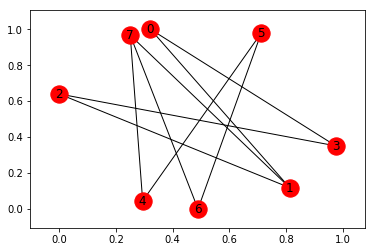

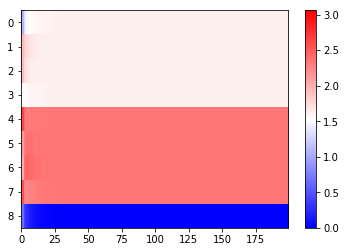

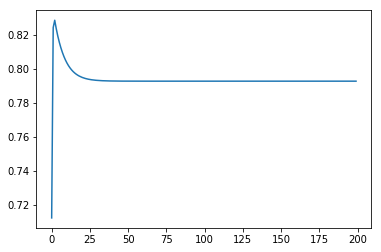

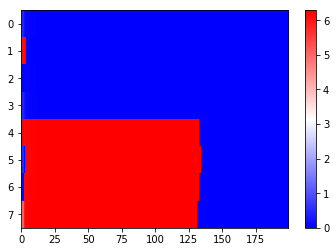

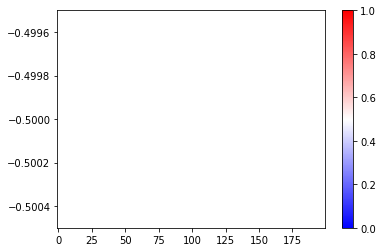

In [342]:
# 0-0
Nn=8
Ne=9
Nf=0
B0=np.zeros((Ne,Nn))
B0[0,:]=[-1, 1, 0, 0, 0, 0, 0, 0]
B0[1,:]=[0, -1, 1, 0, 0, 0, 0, 0]
B0[2,:]=[0, 0, -1, 1, 0, 0, 0, 0]
B0[3,:]=[1, 0, 0, -1, 0, 0, 0, 0]
B0[4,:]=[0, 0, 0, 0, -1, 1, 0, 0]
B0[5,:]=[0, 0, 0, 0, 0, -1, 1, 0]
B0[6,:]=[0, 0, 0, 0, 0, 0, -1, 1]
B0[7,:]=[0, 0, 0, 0, 1, 0, 0, -1]
B0[8,:]=[0, 1, 0, 0, 0, 0, 0, -1]
B1=np.zeros((Nf,Ne))

G=nx.from_numpy_matrix(B0.T.dot(B0))
nx.draw_networkx(G)

# np.random.seed(seed=4444)

theta_0=np.pi*np.random.rand(Ne)
# theta_0=(np.random.rand(Ne)-0.5)*2
# theta_0=np.ones(Ne)
# theta_0=np.pi*np.ones(Ne)*3/2+0.1

omega_0=np.ones(Ne)*0

degree=np.absolute(B0).sum(0)
a=1

t_max = 110 #integration time
n_t = 200 #number of timepoints 

result=integrate_simplicial_kuramoto_full_theta(B0, B1, theta_0, t_max, n_t, a, omega_0, degree, wn, we, wf)

times = result.t
theta = result.y
# theta = np.mod(result.y,2*np.pi)

plt.figure()
plt.imshow(np.mod(np.around(theta,10),np.around(2*np.pi,10)), aspect='auto',cmap='bwr')
plt.colorbar()

op=order_parameter(theta, 4, 1)
plt.figure()
plt.plot(op[0,:])

Div=np.mod(np.around(B0.T.dot(theta),10),np.around(2*np.pi,10))
Curl=np.mod(np.around(B1.dot(theta),10),np.around(2*np.pi,10))
print('Div: ', Div[:,-1])
print('Curl: ', Curl[:,-1])
print('\theta_0,\theta: ', theta_0,theta[:,-1])
L1=-B0.dot(B0.T)-B1.T.dot(B1)
print('L1\theta: ', L1.dot(theta[:,-1]))
print('L1\theta: ', np.mod(np.around(L1.dot(theta[:,-1]),10),np.around(2*np.pi,10)))
print('dim(Ker(L1)): ', null_space(L1).shape[1])
print('Ker(L1): ', null_space(L1))

plt.figure()
plt.imshow(Div, aspect='auto',cmap='bwr')
plt.colorbar()
plt.figure()
plt.imshow(Curl, aspect='auto',cmap='bwr')
plt.colorbar() 

('Div: ', array([0., 0., 0., 0., 0.]))
('Curl: ', array([0.]))
('\theta_0,\theta: ', array([0.22099911, 2.57610368, 5.96327978, 5.11838937, 4.52163246,
       0.05352753]), array([-0.54244599, -0.18081533,  6.10236998,  5.74073931,  5.74073931,
        0.36163066]))
('L1\theta: ', array([ 6.28318531e+00, -1.02140518e-14, -1.25663706e+01,  1.77635684e-14,
       -6.28318531e+00, -6.28318531e+00]))
('L1\theta: ', array([0., 0., 0., 0., 0., 0.]))
('dim(Ker(L1)): ', 1)
('Ker(L1): ', array([[-0.52223297],
       [-0.17407766],
       [-0.17407766],
       [-0.52223297],
       [-0.52223297],
       [ 0.34815531]]))


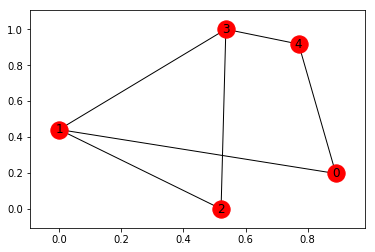

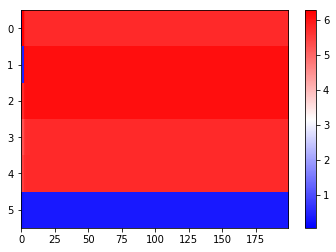

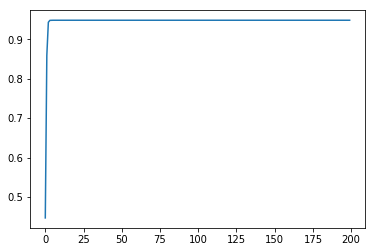

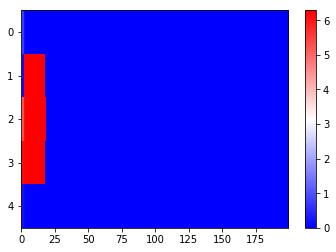

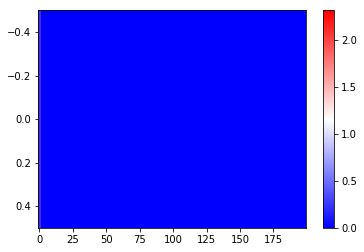

In [28]:
# cycle graph
Nn=5
Ne=6
Nf=1

# +-
B0=np.zeros((Ne,Nn))
B0[0,:]=[1, -1, 0, 0, 0]
B0[1,:]=[0, 1, -1, 0, 0]
B0[2,:]=[0, 0, 1, -1, 0]
B0[3,:]=[0, 0, 0, 1, -1]
B0[4,:]=[-1, 0, 0, 0, 1]
B0[5,:]=[0, -1, 0, 1, 0]

B1=np.zeros((Nf,Ne))
B1[0,:]=[0, 1, 1, 0, 0, 1]

G=nx.from_numpy_matrix(B0.T.dot(B0))
nx.draw_networkx(G)

# np.random.seed(seed=4444)

theta_0=2*np.pi*np.random.rand(Ne)
# theta_0=(np.random.rand(Ne)-0.5)*10
# theta_0=np.mod(theta_0,2*np.pi)
# theta_0=np.pi*np.ones(Ne)*3/2+0.1
omega_0=np.ones(Ne)*0

degree=np.absolute(B0).sum(0)
a=1

t_max = 200 #integration time
n_t = 200 #number of timepoints 

result=integrate_simplicial_kuramoto_full_theta(B0, B1, theta_0, t_max, n_t, a, omega_0, degree, wn, we, wf)

times = result.t
theta = result.y

plt.figure()
plt.imshow(np.mod(np.around(theta,10),np.around(2*np.pi,10)), aspect='auto',cmap='bwr')
plt.colorbar()

op=order_parameter(theta, 4, 1)
plt.figure()
plt.plot(op[0,:])

Div=np.mod(np.around(B0.T.dot(theta),10),np.around(2*np.pi,10))
Curl=np.mod(np.around(B1.dot(theta),10),np.around(2*np.pi,10))
print('Div: ', Div[:,-1])
print('Curl: ', Curl[:,-1])
print('\theta_0,\theta: ', theta_0,theta[:,-1])
L1=-B0.dot(B0.T)-B1.T.dot(B1)
print('L1\theta: ', L1.dot(theta[:,-1]))
print('L1\theta: ', np.mod(np.around(L1.dot(theta[:,-1]),10),np.around(2*np.pi,10)))
print('dim(Ker(L1)): ', null_space(L1).shape[1])
print('Ker(L1): ', null_space(L1))

plt.figure()
plt.imshow(Div, aspect='auto',cmap='bwr')
plt.colorbar()
plt.figure()
plt.imshow(Curl, aspect='auto',cmap='bwr')
plt.colorbar() 

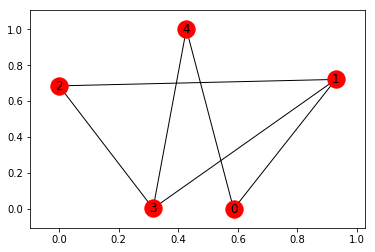

In [78]:
# cycle graph
Nn=5
Ne=6
Nf=1

# +-
B0=np.zeros((Ne,Nn))
B0[0,:]=[1, -1, 0, 0, 0]
B0[1,:]=[0, 1, -1, 0, 0]
B0[2,:]=[0, 0, 1, -1, 0]
B0[3,:]=[0, 0, 0, 1, -1]
B0[4,:]=[-1, 0, 0, 0, 1]
B0[5,:]=[0, -1, 0, 1, 0]

B1=np.zeros((Nf,Ne))
B1[0,:]=[0, 1, 1, 0, 0, 1]

G=nx.from_numpy_matrix(B0.T.dot(B0))
nx.draw_networkx(G)

In [179]:
B0d=np.concatenate((B0,-B0),axis=0)
B1d=np.concatenate((B1,-B1),axis=1)
B0dp=(np.abs(B0d)+B0d)/2
B0dm=(np.abs(B0d)-B0d)/2
B1dp=(np.abs(B1d)+B1d)/2
B1dm=(np.abs(B1d)-B1d)/2
V=np.concatenate((np.eye(Ne),-np.eye(Ne)),axis=0)
print(B0d)
print(B0dm)

[[ 1. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
 [ 0.  1. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1. -1.]
 [-1.  1. -0. -0. -0. -0. -0. -0. -0. -0.]
 [-1. -0. -0. -0. -0. -0. -0. -0. -0.  1.]
 [-0. -1.  1. -0. -0. -0. -0. -0. -0. -0.]
 [-0. -0. -1.  1. -0. -0. -0. -0. -0. -0.]
 [-0. -0. -0. -1.  1. -0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -1.  1. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0. -1.  1. -0. -0. -0.]
 [-0. -0. -0. -0. -0. -0. -1.  1. -0. -0.]
 [-0. -0. -0. -0. -0. -0. -0. -1.  1. -0.]
 [-0. -0. -0. -0. -0. -0. -0. -0. -1.  1.]]
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0.

In [156]:
L0=B0.T.dot(B0)
L0d=B0dp.T.dot(B0d)
L1=B0.dot(B0.T)+B1.T.dot(B1)
L1d=V.T.dot(B0dm.dot(B0dp.T)+B0dp.dot(B0dm.T)+B1dp.T.dot(B1dm)+B1dm.T.dot(B1dp)).dot(V)/2
print(L1-L1d)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [144]:
# print(V.T.dot(B0dm.dot(B0d.T)).dot(V))
# print(V.T.dot(B0dp.dot(B0d.T)).dot(V))
# print(V.T.dot(B0dm.dot(B0dm.T)).dot(V))
# print(V.T.dot(B0dp.dot(B0dp.T)).dot(V))
# print(V.T.dot(B0dp.dot(B0dp.T)).dot(V)-V.T.dot(B0dm.dot(B0dm.T)).dot(V))
# print(V.T.dot(B0dp.dot(B0dp.T)-B0dm.dot(B0dm.T)).dot(V))

In [300]:
def simplicial_kuramoto_full_theta_double(t, theta, B0d, B0dp, B0dm, B1d, B1dp, B1dm, a, omega_0, degree, weights_n, weights_e, weights_f):
#     return omega_0-a*(B0d.dot(np.sin(B0d.T.dot(theta))))-a*B1d.T.dot(np.sin(B1d.dot(theta)))+a*(B0d.dot(np.sin(B0d.T.dot(theta))))+a*B1dp.T.dot(np.sin(B1dp.dot(theta)))+a*(B0dm.dot(np.sin(B0dm.T.dot(theta))))+a*B1dm.T.dot(np.sin(B1dm.dot(theta)))
    return omega_0-a*(B0d.dot(np.sin(B0d.T.dot(theta))))

def integrate_simplicial_kuramoto_full_theta_double(B0d, B0dp ,B0dm, B1d, B1dp, B1dm, theta_0, t_max, n_t, a, omega_0, degree, weights_n, weights_e, weights_f):
    
    return integ.solve_ivp(lambda t, theta: simplicial_kuramoto_full_theta_double(t, theta, B0d, B0dp ,B0dm, B1d, B1dp, B1dm, a, omega_0, degree, weights_n, weights_e, weights_f), [0, t_max], theta_0, t_eval = np.linspace(0, t_max, n_t),method='Radau',rtol=1.49012e-8,atol=1.49012e-8)

In [301]:
def simplicial_kuramoto_full_theta_double_adj(t, theta, Au, Ad, a, omega_0, degree, weights_n, weights_e, weights_f):
    Ne=Au.shape[0]
#     return omega_0+a*(np.multiply(Au,np.sin(np.reshape(np.repeat(theta_0d,Ne),(Ne,Ne)).T-np.reshape(np.repeat(theta_0d,Ne),(Ne,Ne))))
#                       +np.multiply(Ad,np.sin(np.reshape(np.repeat(theta_0d,Ne),(Ne,Ne)).T-np.reshape(np.repeat(theta_0d,Ne),(Ne,Ne))))).sum(1)
    return omega_0+a*(np.multiply(Au+Ad,np.sin(np.reshape(np.repeat(theta_0d,Ne),(Ne,Ne)).T-np.reshape(np.repeat(theta_0d,Ne),(Ne,Ne))))).sum(1)
                


def integrate_simplicial_kuramoto_full_theta_double_adj(Au, Ad, theta_0, t_max, n_t, a, omega_0, degree, weights_n, weights_e, weights_f):
    
    return integ.solve_ivp(lambda t, theta: simplicial_kuramoto_full_theta_double_adj(t, theta, Au, Ad, a, omega_0, degree, weights_n, weights_e, weights_f), [0, t_max], theta_0, t_eval = np.linspace(0, t_max, n_t),method='Radau',rtol=1.49012e-8,atol=1.49012e-8)

edges
[[0. 1.]
 [0. 9.]
 [1. 2.]
 [2. 3.]
 [3. 4.]
 [4. 5.]
 [5. 6.]
 [6. 7.]
 [7. 8.]
 [8. 9.]]
faces
[]
('\theta: ', array([-1.76917956,  8.16157168,  0.66227682, -0.7195508 , -9.58167358,
       -3.39507734, -6.48835225, -2.24589581, -9.26972878, -4.63880847]))
('\theta: ', array([4.51400574, 1.87838637, 0.66227682, 5.56363451, 2.98469703,
       2.88810797, 6.07801837, 4.0372895 , 3.29664183, 1.64437684]))
('Div: ', array([0.10920681, 2.43145638, 4.90135769, 3.70424783, 6.18659624,
       3.1899104 , 4.24245644, 5.54253765, 4.63092031, 2.7604221 ]))
('Curl: ', array([], dtype=float64))
('\theta_0,\theta: ', array([ 1.46562542e-04, -4.21867806e-04,  1.51392701e-05,  1.09834714e-04,
        4.63926402e-04,  2.78073063e-04,  3.55603551e-04,  2.33282258e-04,
        4.82499374e-04,  3.44040238e-04]), array([-1.76917956,  8.16157168,  0.66227682, -0.7195508 , -9.58167358,
       -3.39507734, -6.48835225, -2.24589581, -9.26972878, -4.63880847]))
('L1\theta: ', array([ -3.96093573,  -9.91

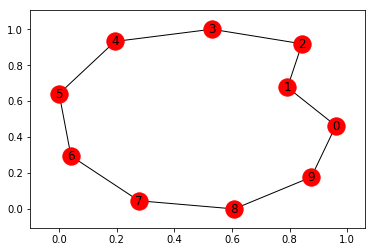

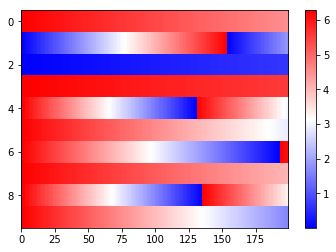

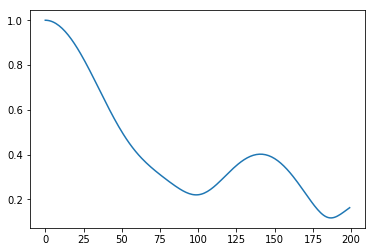

In [303]:
# no weights
G=nx.cycle_graph(10)

nx.draw_networkx(G)

A=nx.to_numpy_matrix(G)

B0,B1=ntri(A)

# print B0
# print B1

# B0[1,0]=-B0[1,0]
# B0[1,9]=-B0[1,9]

Nn=B0.shape[1]
Ne=B0.shape[0]
Nf=B1.shape[0]
wn=np.ones(Nn)
we=np.ones(Ne)
wf=np.ones(Nf)

V=np.concatenate((np.eye(Ne),-np.eye(Ne)),axis=0)
B0d=V.dot(B0)
# B0d=np.concatenate((B0,-B0),axis=0)
B1d=B1.dot(V.T)
# B1d=np.concatenate((B1,-B1),axis=1)
B0dp=(np.abs(B0d)+B0d)/2
B0dm=(np.abs(B0d)-B0d)/2
B1dp=(np.abs(B1d)+B1d)/2
B1dm=(np.abs(B1d)-B1d)/2

# np.random.seed(seed=4444)

# theta_0=np.pi*np.random.rand(Ne)
theta_0=(np.random.rand(Ne)-0.5)*0.001
theta_0d=V.dot(theta_0)
# theta_0=np.pi*np.ones(Ne)*3/2+0.1

omega_0=np.ones(2*Ne)*0

degree=np.absolute(B0).sum(0)
a=1

t_max = 2000 #integration time
n_t = 200 #number of timepoints 

# result=integrate_simplicial_kuramoto_full_theta_double(B0d, B0dp ,B0dm, B1d, B1dp, B1dm, theta_0d, t_max, n_t, a, omega_0, degree, wn, we, wf)

# times = result.t
# theta = result.y
# theta=V.T.dot(theta)

Ad=B0dm.dot(B0dp.T)+B0dp.dot(B0dm.T)
Au=B1dp.T.dot(B1dm)+B1dm.T.dot(B1dp)

result=integrate_simplicial_kuramoto_full_theta_double_adj(Au, Ad, theta_0d, t_max, n_t, a, omega_0, degree, wn, we, wf)

times = result.t
theta = result.y
theta=V.T.dot(theta)

plt.figure()
plt.imshow(np.mod(np.around(theta,10),np.around(2*np.pi,10)), aspect='auto',cmap='bwr')
plt.colorbar()

op=order_parameter(theta, 4, 1)
plt.figure()
plt.plot(op[0,:])

print('\theta: ', theta[:,-1])
print('\theta: ', np.mod(np.around(theta[:,-1],10),np.around(2*np.pi,10)))

Div=np.mod(np.around(B0.T.dot(theta),10),np.around(2*np.pi,10))
Curl=np.mod(np.around(B1.dot(theta),10),np.around(2*np.pi,10))
print('Div: ', Div[:,-1])
print('Curl: ', Curl[:,-1])
print('\theta_0,\theta: ', theta_0,theta[:,-1])
L1=-B0.dot(B0.T)-B1.T.dot(B1)
print('L1\theta: ', L1.dot(theta[:,-1]))
print('L1\theta: ', np.mod(np.around(L1.dot(theta[:,-1]),10),np.around(2*np.pi,10)))
print('dim(Ker(L1)): ', null_space(L1).shape[1])
print('Ker(L1): ', null_space(L1))

# plt.figure()
# plt.imshow(Div, aspect='auto',cmap='bwr')
# plt.colorbar()
# plt.figure()
# plt.imshow(Curl, aspect='auto',cmap='bwr')
# plt.colorbar() 